In [7]:
!pip install numpy pandas seaborn matplotlib statsmodels


[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# EDA

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei',"SimHei"]
plt.rcParams['axes.unicode_minus'] = False

#base_path=Path("datas")

## 数据基本信息

In [12]:
electricity_price=pd.read_csv('datas/electricity_price_parsed.csv',parse_dates=["timestamp"],index_col=0)
electricity_price.columns = ["demand", "price"]
electricity_price.head()

FileNotFoundError: [Errno 2] No such file or directory: 'datas/electricity_price_parsed.csv'

In [ ]:
# 创建测试集掩码，标记出所有价格为 NaN 的数据行
test_mask = electricity_price["price"].isna()

# 创建训练集掩码，标记出所有价格不为 NaN 的数据行,其中~代表布尔取反，即True和False互换。 `[True,False]`和 `~[False,True]`一致
train_mask = ~test_mask

# 打印训练集的范围和总长度
# 训练集范围从训练集中最早的日期到最新的日期
print(f"训练集范围：{electricity_price[train_mask].index.min()} --> {electricity_price[train_mask].index.max()}\t总长度{len(electricity_price[train_mask])}")

# 打印测试集的范围和总长度
# 测试集范围从测试集中最早的日期到最新的日期
print(f"测试集范围：{electricity_price[test_mask].index.min()} --> {electricity_price[test_mask].index.max()}\t总长度{len(electricity_price[test_mask])}")


训练集范围：2021-12-01 00:15:00 --> 2023-07-01 00:00:00	总长度55392
测试集范围：2023-07-01 00:15:00 --> 2024-04-19 00:00:00	总长度28128


确认是否有缺失值，可以发现除了测试集部分，其他均无缺失

In [ ]:
electricity_price.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83520 entries, 2021-12-01 00:15:00 to 2024-04-19 00:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  83520 non-null  float64
 1   price   55392 non-null  float64
dtypes: float64(2)
memory usage: 1.9 MB


进一步观察数据，发现数据中的出清价格在一小时内都是相同的，但负荷会在一小时中变动

我们可以写一个简单函数确认一下

In [ ]:
electricity_price.head(12)

,demand,price
timestamp,,
2021-12-01 00:15:00,40334.18,350.80
2021-12-01 00:30:00,40523.15,350.80
2021-12-01 00:45:00,40374.74,350.80
2021-12-01 01:00:00,40111.55,350.80
2021-12-01 01:15:00,40067.50,348.93
2021-12-01 01:30:00,39562.02,348.93
2021-12-01 01:45:00,39629.90,348.93
2021-12-01 02:00:00,39121.31,348.93
2021-12-01 02:15:00,39124.08,347.01


In [ ]:
def check_repeated(data, repeat_count=4):    
    """
    检查给定数据序列中是否存在元素不断重复的情况。

    参数:
    data (list): 要检查的序列数据。
    repeat_count (int): 每个元素应重复的次数。默认值为4。

    返回:
    None
    """
    # 以步长 repeat_count 遍历 data 的索引
    for i in range(0, len(data), repeat_count):
        # 从索引 i 开始，取长度为 repeat_count 的子序列
        subsequence = data[i:i + repeat_count]
        
        # 如果子序列的独特元素数量不等于 1，则表示不是同一元素重复
        if len(set(subsequence)) != 1:
            print(f"序列数据不是元素不断重复 {repeat_count} 次")
            return  # 发现不满足条件的情况后，直接返回
        
    # 如果遍历完所有子序列，未发现不满足条件的情况，则输出满足条件的信息
    print(f"序列数据是元素不断重复 {repeat_count} 次")

# 调用函数并传入特定的电价数据
check_repeated(electricity_price[train_mask]["price"])


序列数据是元素不断重复 4 次


从图中也能确认，在一小时中出清价格一致
- `.plot(...)` 方法用于绘制图表。
- `y="price"` 指定要绘制的列名，这里是 "price" 列。
- `figsize=(18, 5)` 设置图表的大小，宽度为 18 英寸，高度为 5 英寸。figsize 参数接受一个包含宽度和高度的元组。
- `marker='o'` 设置数据点的标记样式为圆圈。marker 参数用于指定数据点的形状。

Text(0.5, 1.0, '2023年1月3日出清价格走势')

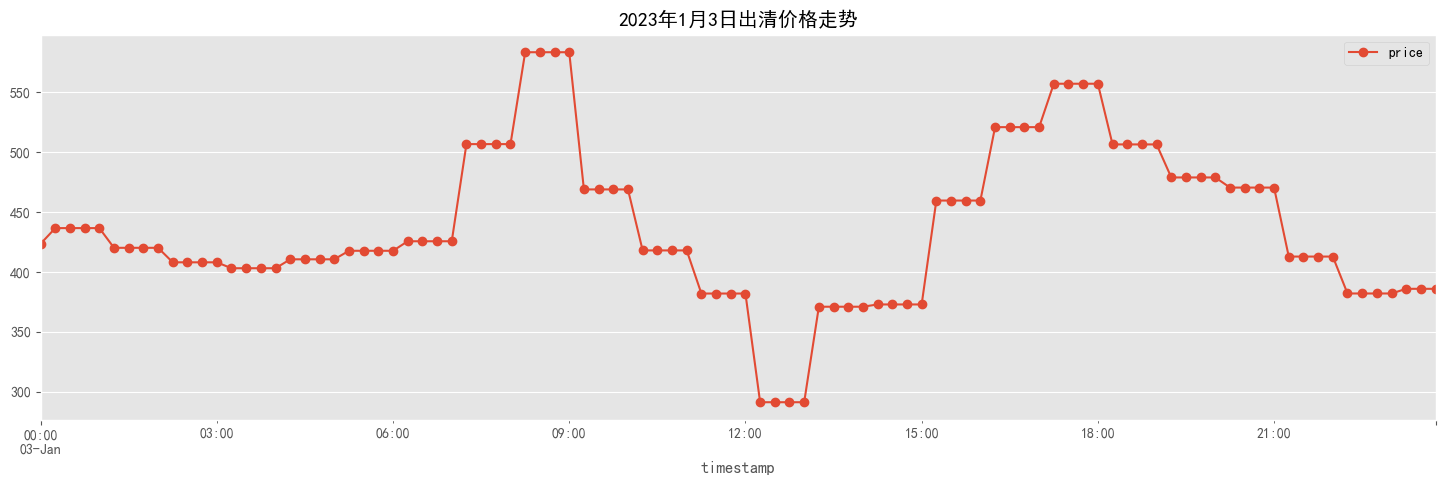

In [ ]:
# 使用loc方法选择指定日期的数据，绘制价格图表
electricity_price.loc["2023-01-03"].plot(y="price", figsize=(18, 5), marker='o')

# 设置图表的标题
plt.title("2023年1月3日出清价格走势")

## 统计指标分析
首先我们从最基本的单变量数值关系入手，探究其统计指标的表现。具体来说可以关注：
- 中心趋势
    - 均值：`df[feature].mean()`
    - 中位数 `df[feature].median()`
    - 最大值 `df[feature].max()`
    - 最小值 `df[feature].min()`
    - 众数 `df[feature].mode()`
- 变异程度
    - 标准差 `df[feature].std()`
    - 极差 `df[feature].apply(lambda x: x.max() - x.min())`
    - 四分位数 `df[feature].quantile([0.25, 0.5, 0.75])`
    - 变异系数 `df[feature].std()/df[feature].mean()`
    - 偏度和峰度 `df[feature].skew()`, `df[feature].kurtosis()`
- 变化率：`df[feature].pct_change()` 计算公式为 $\dfrac{x_2-x_1}{x_1}$


In [ ]:
electricity_price.describe()

,demand,price
count,83520.000000,55392.000000
mean,36595.327516,360.002312
std,9588.519396,203.745125
min,6993.310000,-85.000000
25%,30214.722500,264.142500
50%,36704.025000,401.695000
75%,42868.577500,471.962500
max,75501.330000,1296.000000


### 总负荷和数值分布
可以看出总负荷数值上接近正态分布

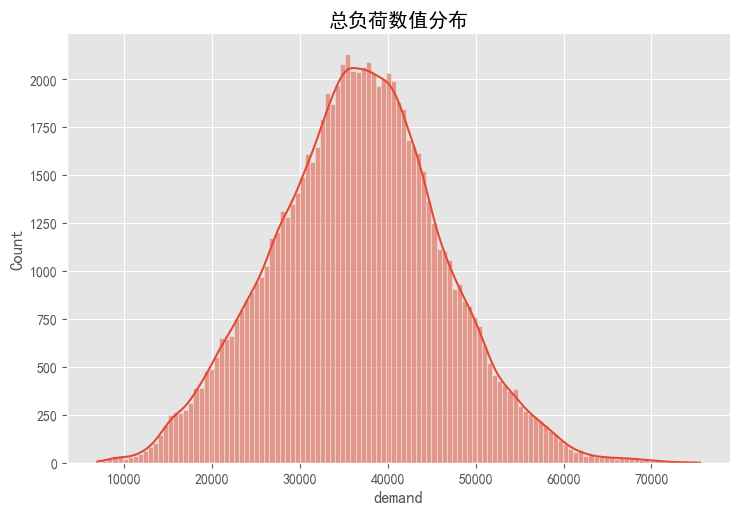

In [ ]:
# 使用 Seaborn 库绘制总负荷数值的分布图
# sns.displot(...) 函数用于绘制数据的分布图
ax = sns.displot(
    electricity_price,  # 输入数据，包含绘制所需的列
    x="demand",         # 指定绘图的列，这里是 "demand" 列
    aspect=1.5,         # 图形的宽高比，1.5 表示宽度是高度的 1.5 倍
    height=5,           # 图形的高度设置为 5 英寸
    kde=True            # 启用核密度估计（KDE），用于绘制数据的平滑概率密度曲线
)

# 设置图形的标题
ax.set(title="总负荷数值分布")


### 出清价格数值分布
可以发现
- 有很多是负价格
- 1-100之间的低价格较多
- 有一定的异常高价（800以上）

<p><strong style="color:red;">这启发我们去探究低价和高价的形成机理，如果能找出引起低价/高价的关键信息，对模型提升会有较大帮助</strong></p>

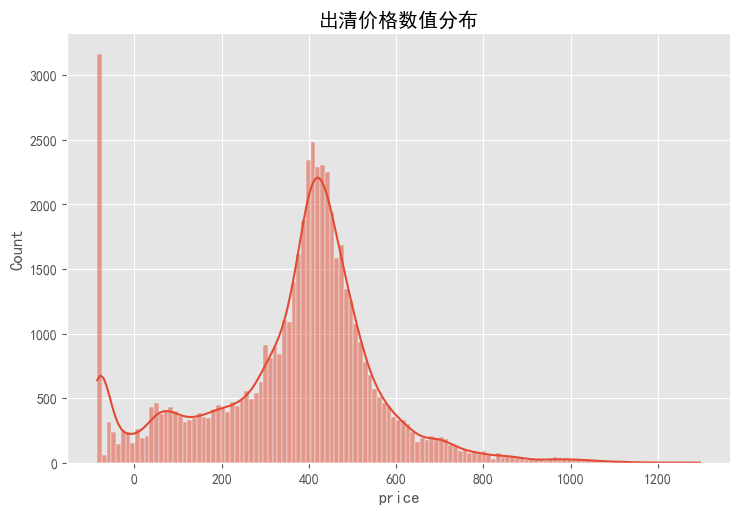

In [ ]:
ax=sns.displot(electricity_price,x="price",aspect=1.5,height=5,kde=True);
ax.set(title="出清价格数值分布")

## 分时统计特征

### 不同小时的总电力需求和电价


In [ ]:
# 从 DataFrame 的索引中提取时间信息，并添加为新的列
# 假设索引为 DatetimeIndex 类型

# 提取小时信息，并创建一个新列 "hour"
electricity_price["hour"] = electricity_price.index.hour
# 提取月份信息，并创建一个新列 "month"
electricity_price["month"] = electricity_price.index.month
# 提取日期信息，并创建一个新列 "day"
electricity_price["day"] = electricity_price.index.day
# 提取星期几的信息（0 = 周一, 6 = 周日），并创建一个新列 "weekday"
electricity_price["weekday"] = electricity_price.index.weekday
# 提取年份信息，并创建一个新列 "year"
electricity_price["year"] = electricity_price.index.year


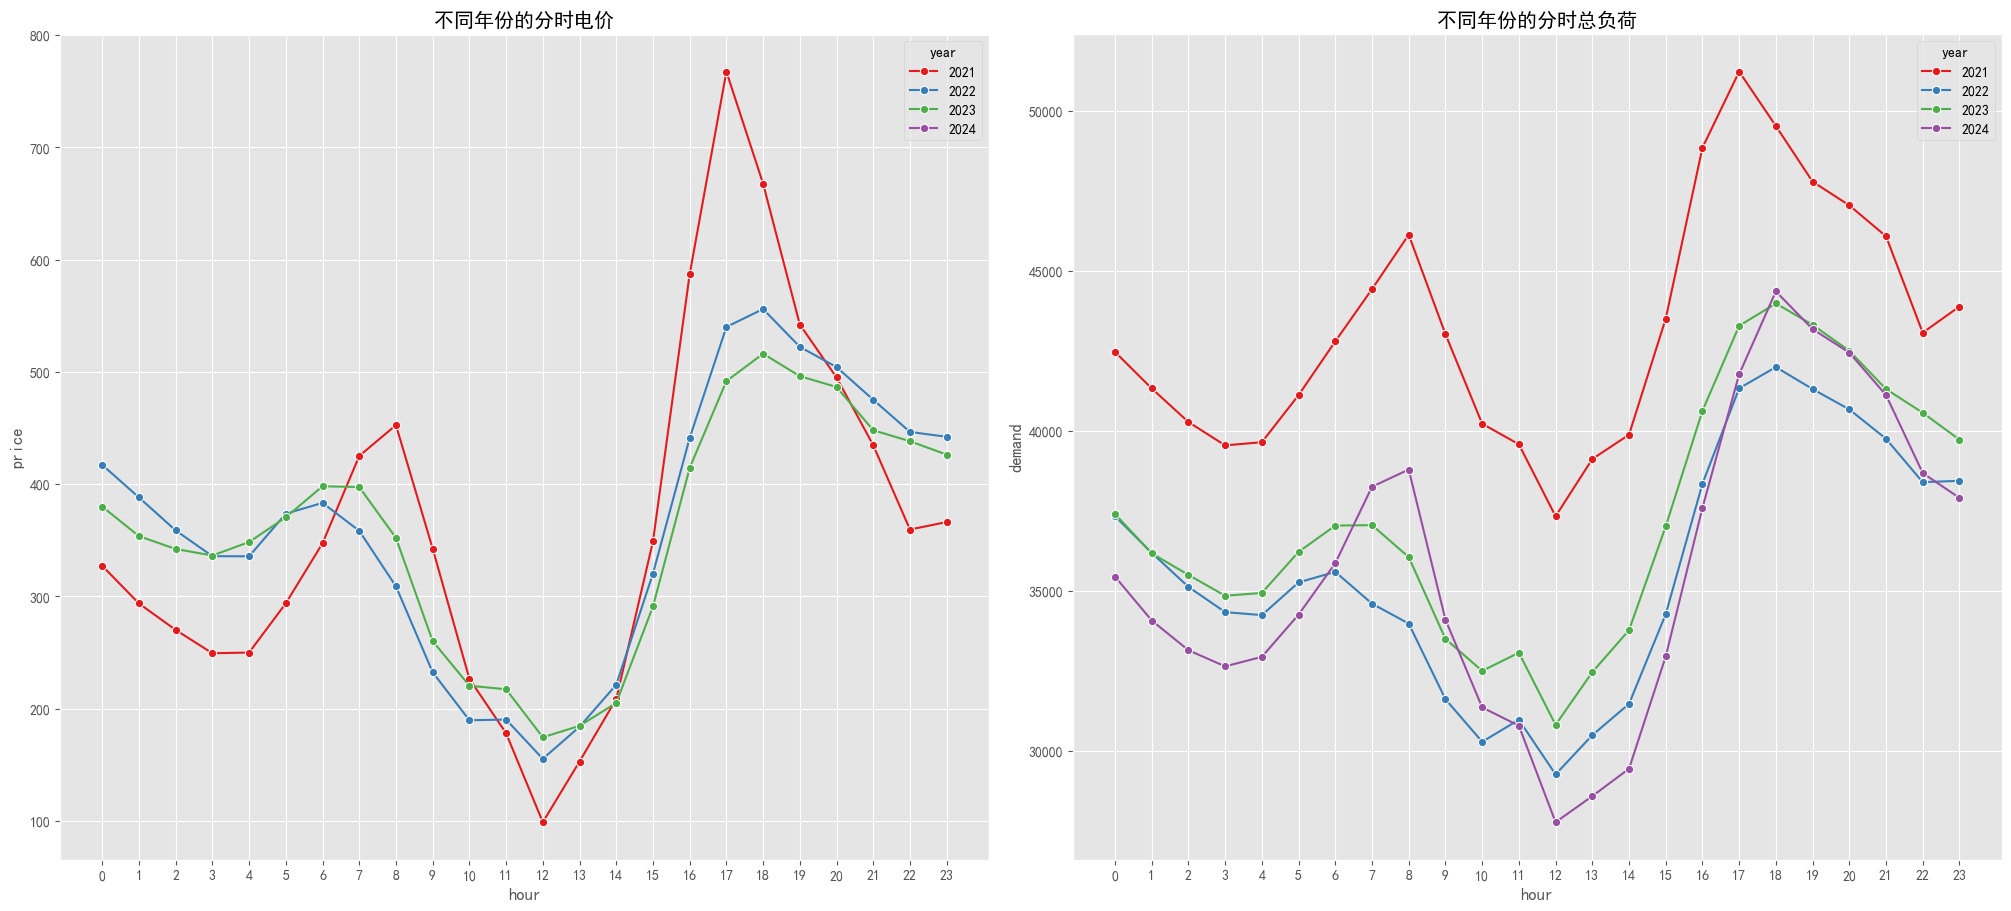

In [ ]:
# 创建一个包含两个子图的绘图区域，图形大小为 20x9 英寸，并启用约束布局
fig, ax = plt.subplots(
    1,                       # 子图的行数为 1
    2,                       # 子图的列数为 2
    figsize=(20, 9),         # 设置整个图形的大小为 20x9 英寸
    constrained_layout=True  # 启用约束布局以自动调整子图位置和大小
)

# 绘制不同年份的分时电价线图
sns.lineplot(
    electricity_price.groupby(["hour", "year"])["price"].mean().reset_index(),  # 按小时和年份分组，计算每组的平均电价，并重置索引
    x="hour",                  # x 轴数据为小时
    y="price",                 # y 轴数据为平均电价
    ax=ax[0],                  # 将图绘制到第一个子图 (ax[0])
    marker="o",                # 数据点标记为圆圈
    hue="year",                # 根据年份不同设置不同的颜色
    palette="Set1"             # 使用 "Set1" 调色板
)
ax[0].set_title("不同年份的分时电价")  # 设置第一个子图的标题
ax[0].set_xticks(range(24))         # 设置 x 轴刻度为 0 到 23（小时范围）

# 绘制不同年份的分时总负荷线图
sns.lineplot(
    electricity_price.groupby(["hour", "year"])["demand"].mean().reset_index(),  # 按小时和年份分组，计算每组的平均总负荷，并重置索引
    x="hour",                  # x 轴数据为小时
    y="demand",                # y 轴数据为平均总负荷
    ax=ax[1],                  # 将图绘制到第二个子图 (ax[1])
    marker="o",                # 数据点标记为圆圈
    hue="year",                # 根据年份不同设置不同的颜色
    palette="Set1"             # 使用 "Set1" 调色板
)
ax[1].set_title("不同年份的分时总负荷")  # 设置第二个子图的标题
ax[1].set_xticks(range(24));         # 设置 x 轴刻度为 0 到 23（小时范围）


透视表（Pivot Table）是一种数据处理工具，用于汇总、分析和比较数据，特别适用于处理大量数据时的复杂数据分析任务。它可以将数据从长格式（详细数据）转换为宽格式（汇总数据），使数据更加易于理解和分析。

**透视表的基本构建要素**
- 行（Index）：透视表的行索引，通常是要分析的主要分类变量。例如，月份或产品类别。
- 列（Columns）:透视表的列索引，通常是次要分类变量。例如，小时或地区。
- 值（Values）:透视表中要进行聚合计算的数据列。例如，价格、销售额或总数。
- 聚合函数（Aggregation Functions）:用于计算汇总数据的函数。例如，sum（求和）、mean（平均值）、count（计数）等。

**透视表示例**

假设有以下销售数据：
```csv
日期,产品,销售额
2024-01-01,A,100
2024-01-01,B,150
2024-02-01,A,200
2024-02-01,B,250
```
可以使用透视表来总结每个月的销售额：

```shell

          | 产品 A | 产品 B |
----------|--------|--------|
2024-01   | 100    | 150    |
2024-02   | 200    | 250    |
```

在这个透视表中：

- 行索引是月份（2024-01, 2024-02）。

- 列索引是产品（A, B）。

- 值是销售额的总和。

In [ ]:
# 创建一个透视表，计算不同月份和时间下的电价
pivot = pd.pivot_table(
    electricity_price,          # 输入的 DataFrame
    values="price",             # 透视表中要填充的值，这里是 "price"
    index="month",              # 设置行索引为月份
    columns="hour"              # 设置列索引为小时
)

# 将透视表中的数据类型转换为整数
pivot = pivot.astype(int)
pivot

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,275,238,214,196,201,233,295,395,490,405,...,240,352,511,656,599,529,515,458,390,340
2,315,277,251,228,231,264,311,391,438,347,...,177,269,403,530,586,545,522,468,408,378
3,385,345,314,295,303,359,437,430,356,222,...,116,215,353,466,542,486,472,423,395,416
4,442,405,372,355,368,429,426,363,245,127,...,119,198,325,433,503,497,493,463,435,466
5,468,439,415,403,413,469,443,369,251,148,...,161,251,352,422,468,475,479,471,460,469
6,470,453,447,441,447,452,417,338,256,205,...,267,338,433,492,509,509,501,487,490,491
7,385,355,324,293,284,304,304,276,245,269,...,342,389,436,476,513,542,562,557,541,465
8,440,390,344,306,289,315,340,318,273,293,...,443,516,594,633,648,669,648,620,627,542
9,513,503,475,449,456,504,498,375,234,118,...,164,317,484,590,628,572,504,462,463,493


Text(0.5, 1.0, '不同月份和时间下的电价')

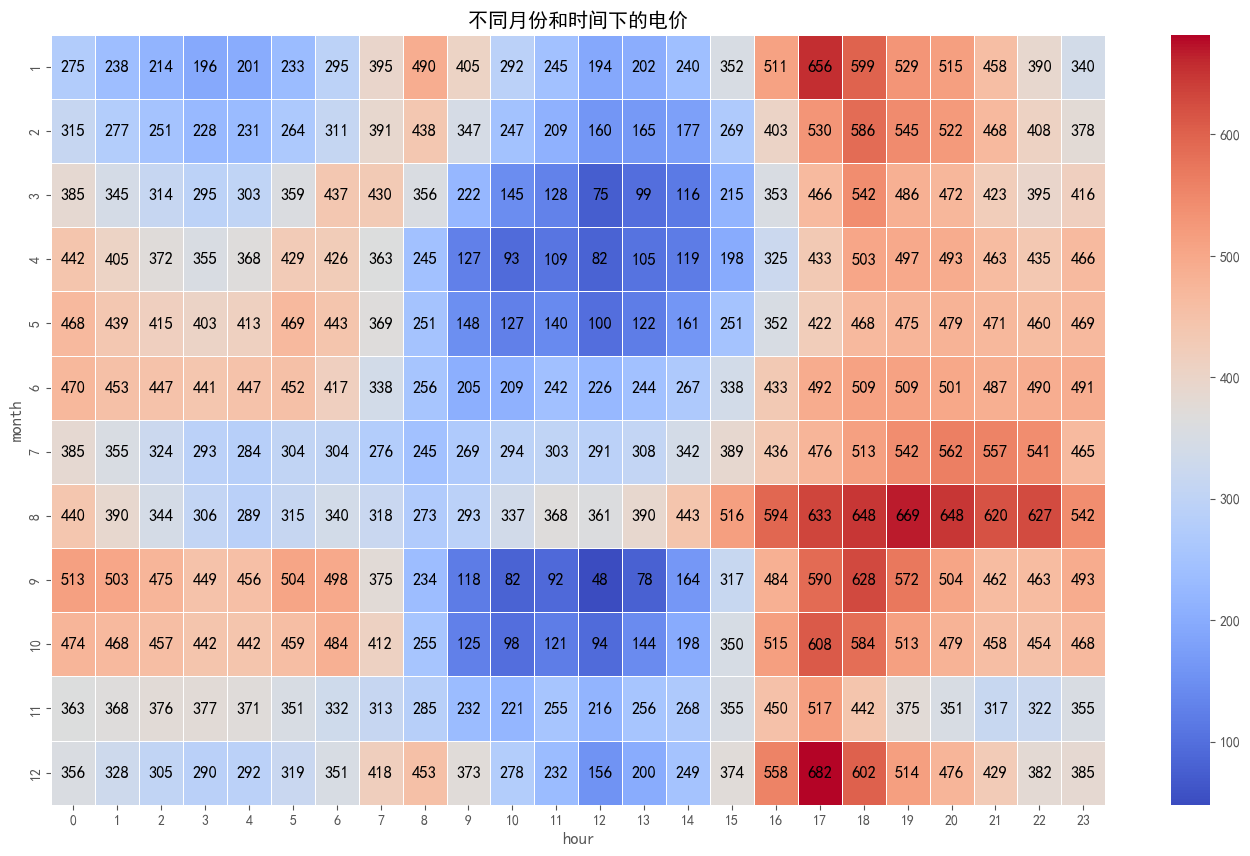

In [ ]:
# 创建一个图形，大小为 17x10 英寸
plt.figure(figsize=(17, 10))

# 绘制热图，显示不同月份和时间下的电价
sns.heatmap(
    pivot,                      # 透视表数据
    cmap="coolwarm",            # 使用 "coolwarm" 调色板，显示热图的颜色
    linewidths=0.5,             # 设置单元格之间的分隔线宽度为 0.5
    annot=True,                 # 启用单元格值的注释
    fmt=".0f",                  # 注释的格式为整数
    annot_kws={"size": 12,      # 注释文本的大小设置为 12
               "weight": "bold",  # 注释文本的字体加粗
               "color": "black"}  # 注释文本的颜色为黑色
)

# 设置图形的标题
plt.title("不同月份和时间下的电价")

## 负电价

In [ ]:
minus_mask = electricity_price["price"] < 0

[Text(0.5, 1.0, '负电量频数出现的小时分布')]

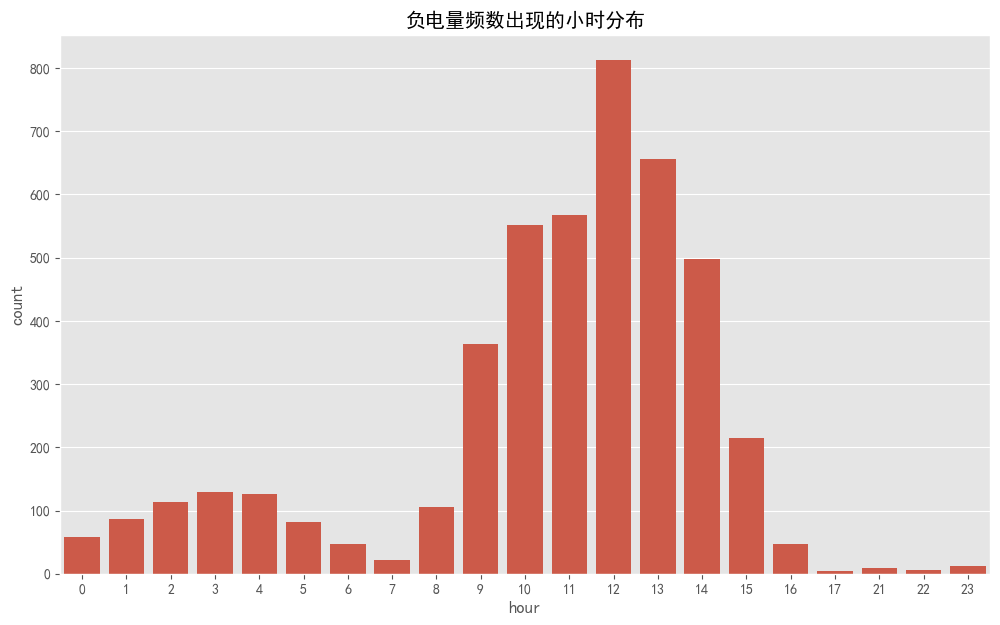

In [ ]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(electricity_price[minus_mask], x="hour")
ax.set(title="负电量频数出现的小时分布")

[Text(0.5, 1.0, '负电量频数出现的月分布')]

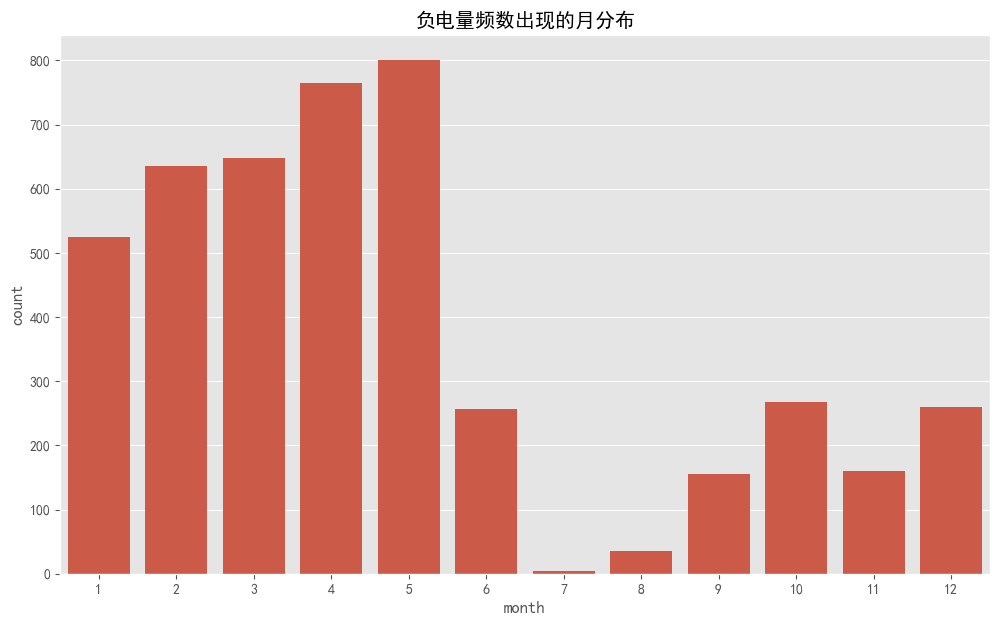

In [ ]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(electricity_price[minus_mask], x="month")
ax.set(title="负电量频数出现的月分布")

统计一下负电价出现最多的日期

In [ ]:
(
    # 选择不满足 minus_mask 条件的数据
    electricity_price[minus_mask]
    # 按月份和日期分组，计算每个组合的记录数量
    .groupby(["month", "day"])["price"]
    .size()                      # 计算每个分组的大小（即每个分组的记录数）
    .reset_index()              # 重置索引，使 groupby 结果成为 DataFrame，并保留分组字段为列
    .sort_values("price",       # 按 "price" 列排序
                 ascending=False)        # 降序排序
    .head(15)                   # 选择排序后的前 15 行
)

,month,day,price
94,5,2,88
20,2,1,76
72,4,5,68
98,5,6,68
93,5,1,68
76,4,9,64
77,4,10,60
19,1,31,57
171,11,29,56
41,2,26,56


Text(0.5, 1.0, '一段比较典型的负电价趋势：2022年5月1日 - 2022年5月9日')

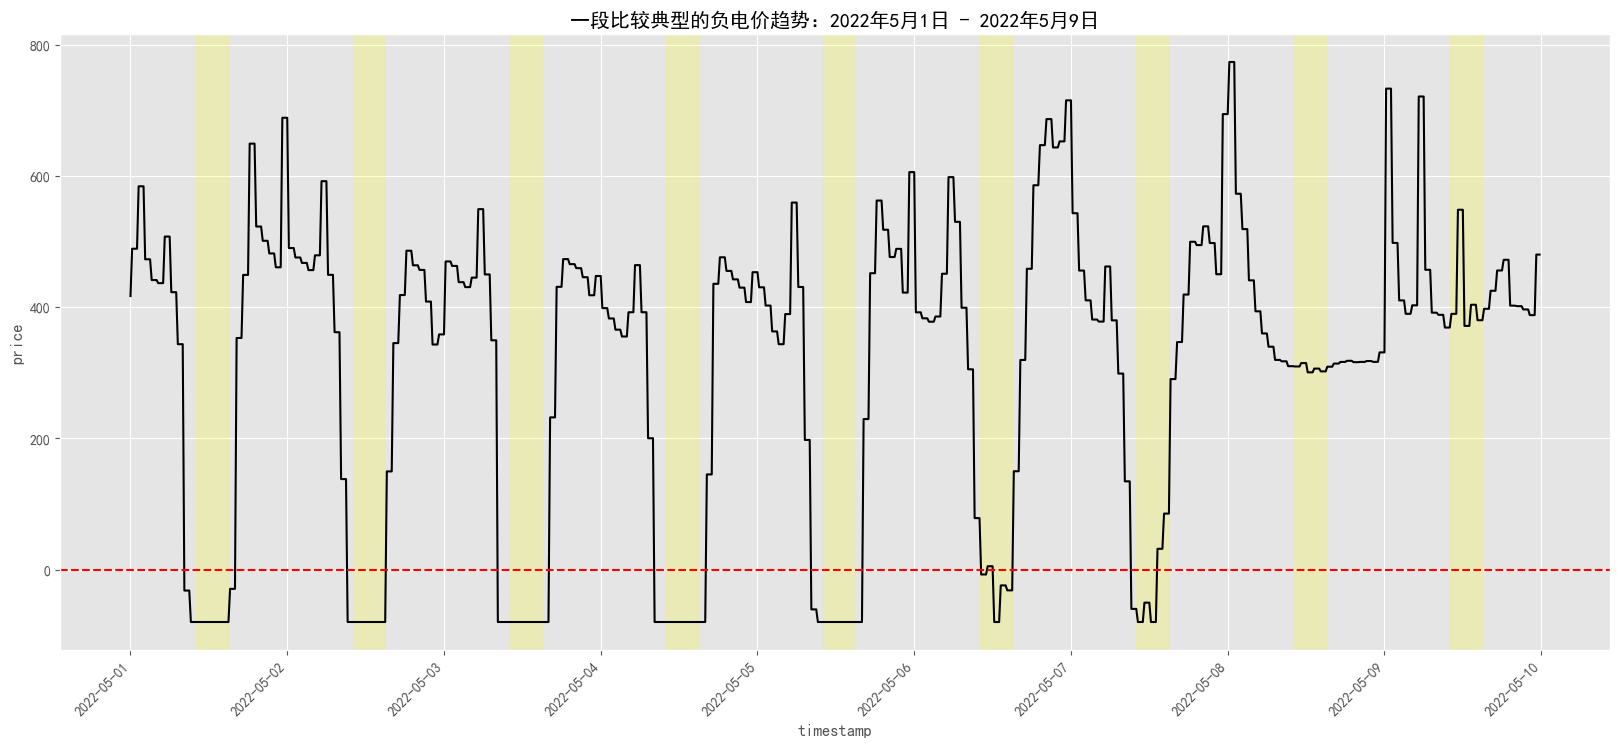

In [ ]:
# 创建一个图形，大小为 20x8 英寸
plt.figure(figsize=(20, 8))

# 绘制从 2022年5月1日到2022年5月9日的电价数据的折线图
ax = sns.lineplot(
    electricity_price.loc["2022-05-01":"2022-05-09"]["price"],  # 从 DataFrame 中选择时间范围内的电价数据
    color="black"  # 设置折线的颜色为黑色
)

# 在每一天的 10:00 到 15:00 之间添加黄色半透明的高亮区域
for i in range(1, 10):
    ax.axvspan(
        f"2022-05-0{i} 10:00:00",  # 高亮区域的开始时间
        f"2022-05-0{i} 15:00:00",  # 高亮区域的结束时间
        color='yellow',            # 高亮区域的颜色为黄色
        alpha=0.2                  # 高亮区域的透明度设置为 0.2（0 完全透明，1 完全不透明）
    )

# 添加一条红色的虚线，y 值为 0，用于显示负电价的参考线
plt.axhline(
    y=0,                      # y 轴的值为 0
    color="red",              # 虚线的颜色为红色
    linestyle="--"           # 虚线的线型为虚线
)

# 设置 x 轴刻度标签的旋转角度为 45 度，并且水平对齐方式为右对齐
plt.setp(
    ax.get_xticklabels(),     # 获取 x 轴刻度标签
    rotation=45,              # 设置标签的旋转角度为 45 度
    ha='right'                # 设置标签的水平对齐方式为右对齐
)

# 设置图形的标题
plt.title("一段比较典型的负电价趋势：2022年5月1日 - 2022年5月9日")

Text(0.5, 1.0, '假期对负电价的影响 2022年1月28日 - 2022年2月6日')

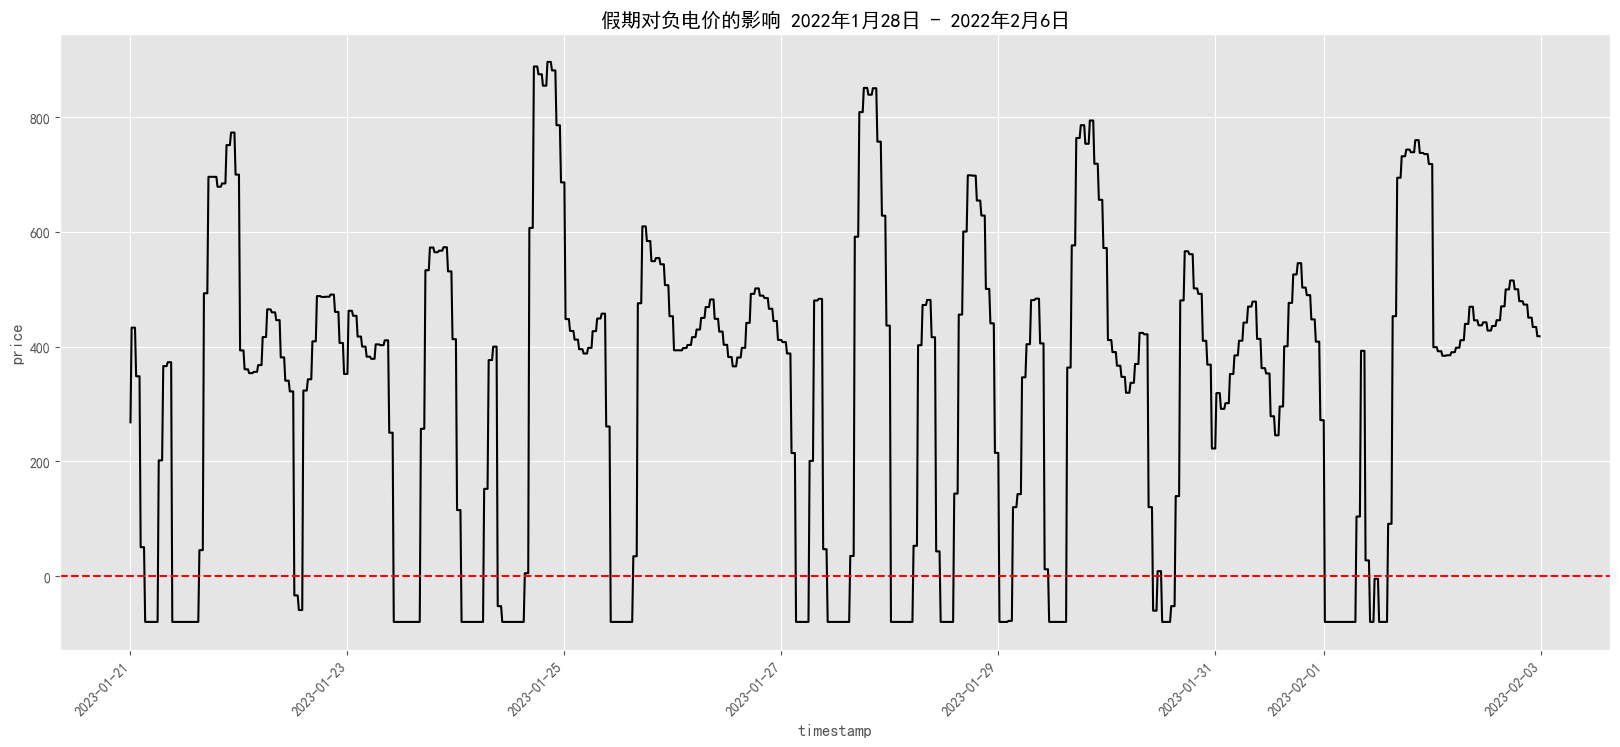

In [ ]:
plt.figure(figsize=(20, 8))
ax = sns.lineplot(electricity_price.loc["2023-01-21":"2023-02-02"]["price"], color="black")
plt.axhline(y=0, color="red", linestyle="--")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("假期对负电价的影响 2022年1月28日 - 2022年2月6日")

## 高电价

In [ ]:
# 计算电价的上限阈值，使用 3 标准差原则来检测异常值
upper_threshold = (
    electricity_price["price"].mean() +      # 电价的均值
    3 * electricity_price["price"].std()      # 加上 3 倍的电价标准差
)

# 创建一个布尔型掩码，用于标识电价高于上限阈值的异常值
high_abnormal_mask = (
    electricity_price["price"] > upper_threshold  # 判断电价是否大于计算得到的上限阈值
)

[Text(0.5, 1.0, '高电量频数出现的小时分布')]

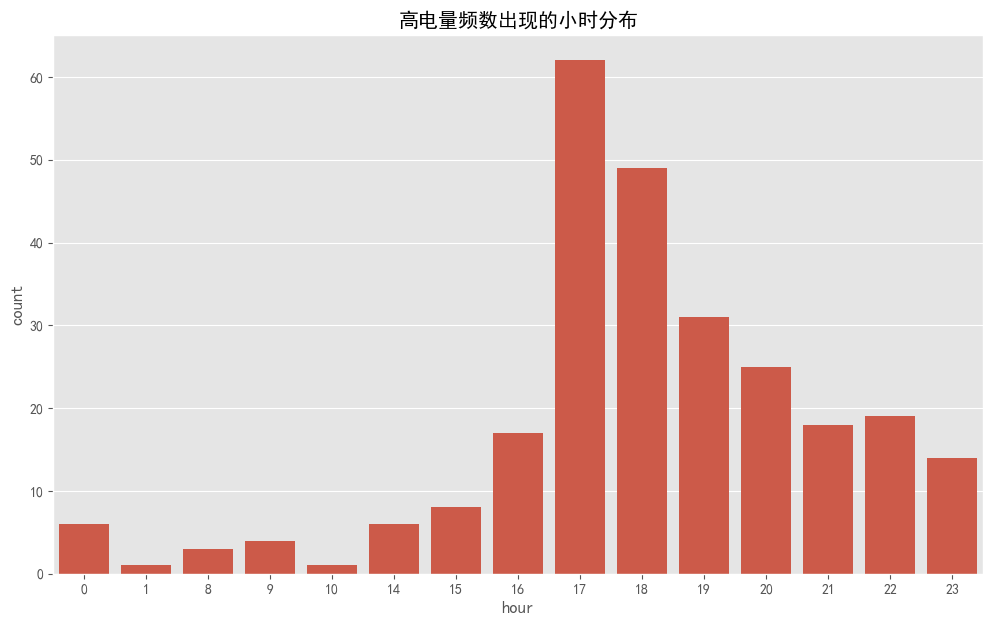

In [ ]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(electricity_price[high_abnormal_mask], x="hour")
ax.set(title="高电量频数出现的小时分布")

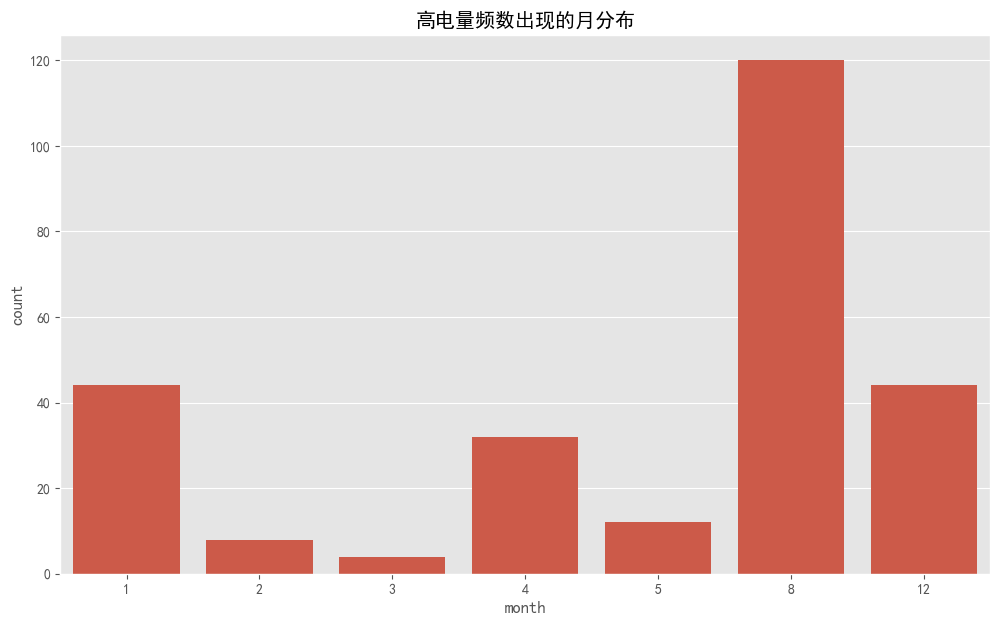

In [ ]:
plt.figure(figsize=(12,7))
ax=sns.countplot(electricity_price[high_abnormal_mask],x="month")
ax.set(title="高电量频数出现的月分布");

In [ ]:
# 从电价数据中筛选出高于上限阈值的异常值
(
electricity_price[high_abnormal_mask]
    # 按月份和日期分组，并计算每个组合的异常值记录数量
    .groupby(["month", "day"])["price"]
    .size()                      # 计算每个分组的大小（即每个分组的记录数）
    .reset_index()              # 重置索引，将分组字段转换为 DataFrame 的列
    .sort_values("price",       # 按 "price" 列排序
        ascending=False)        # 降序排序
    .head(15)                   # 选择排序后的前 15 行
)

,month,day,price
25,8,15,36
22,8,5,36
20,8,3,20
21,8,4,20
17,4,29,16
29,12,29,16
27,12,27,12
18,5,6,11
5,1,10,8
10,2,10,8


Text(0.5, 1.0, '2022年8月1日 - 2022年8月8日 总需求')

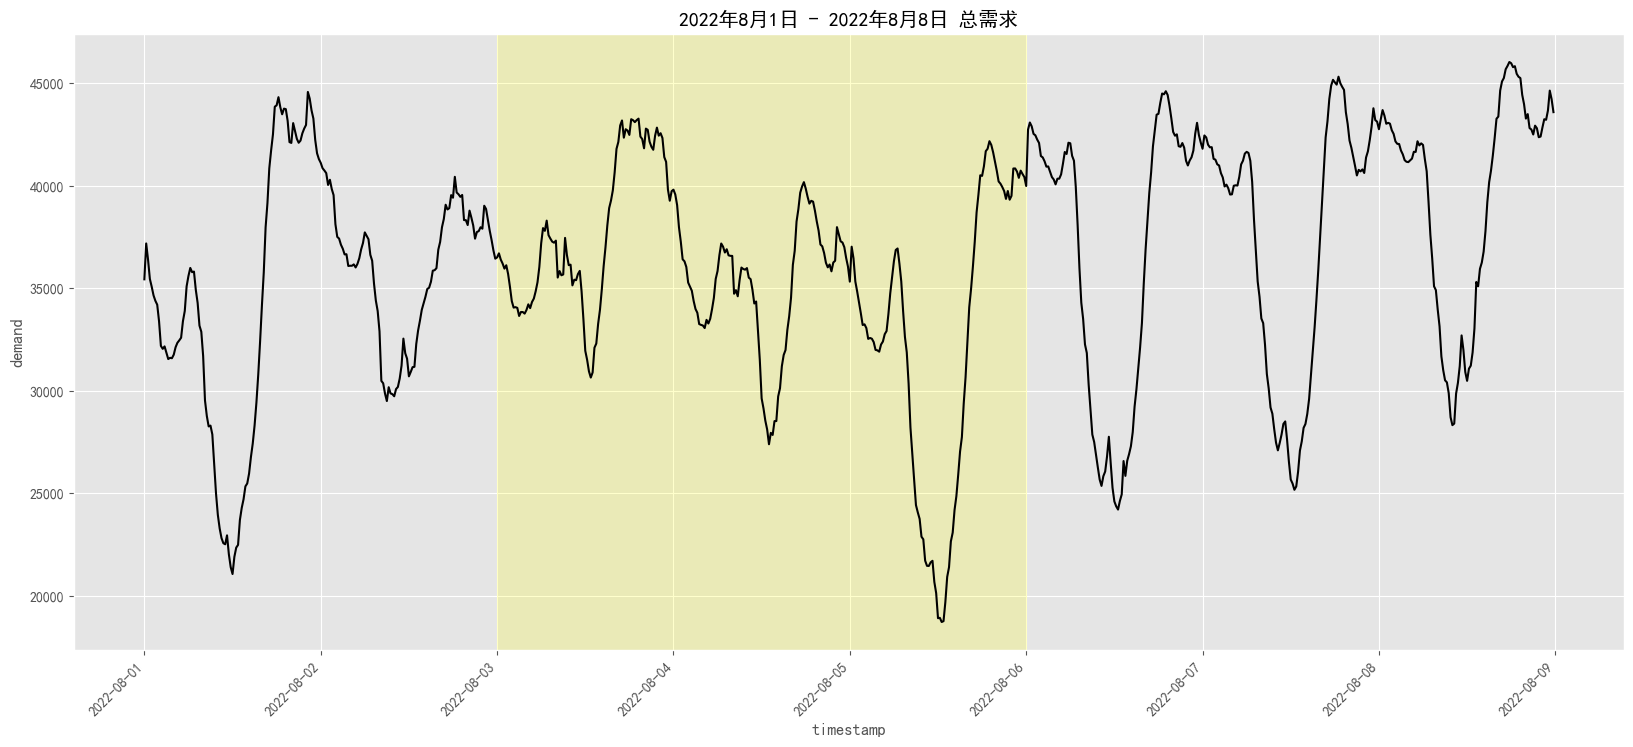

In [ ]:
plt.figure(figsize=(20, 8))
ax = sns.lineplot(electricity_price.loc["2022-08-01":"2022-08-08"]["demand"], color="black")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.axvspan("2022-08-03", "2022-08-06", color="yellow", alpha=0.2)
plt.title("2022年8月1日 - 2022年8月8日 总需求")

Text(0.5, 1.0, '典型高电价时间段 2022年8月1日 - 2022年8月8日 中的3-6日')

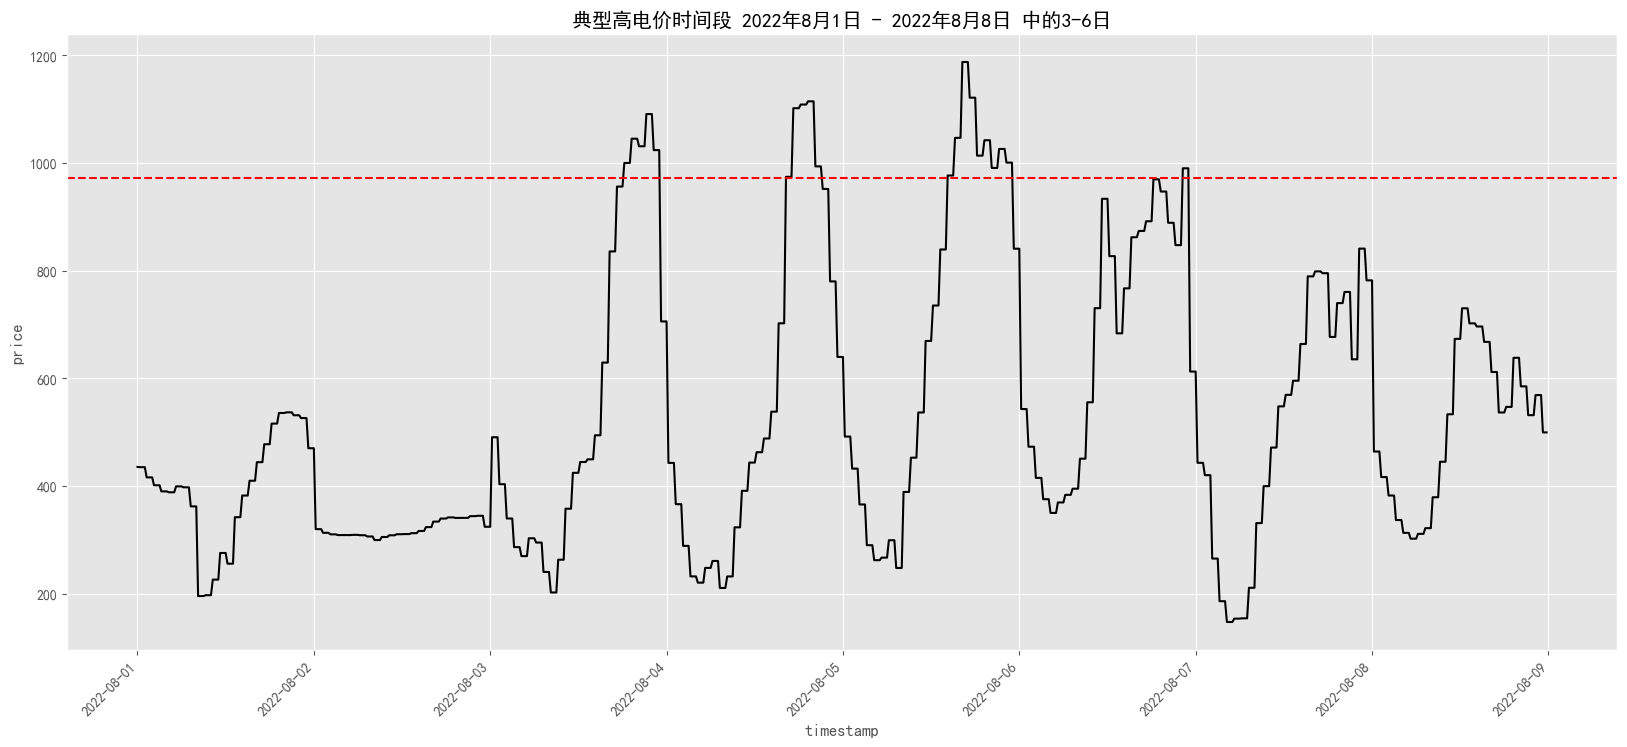

In [ ]:
plt.figure(figsize=(20, 8))
ax = sns.lineplot(electricity_price.loc["2022-08-01":"2022-08-08"]["price"], color="black")
plt.axhline(y=upper_threshold, color="red", linestyle="--")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("典型高电价时间段 2022年8月1日 - 2022年8月8日 中的3-6日")

## 双变量分析

In [ ]:
electricity_price[["demand","price"]].corr()

,demand,price
demand,1.000000,0.343577
price,0.343577,1.000000


<Axes: xlabel='demand', ylabel='price'>

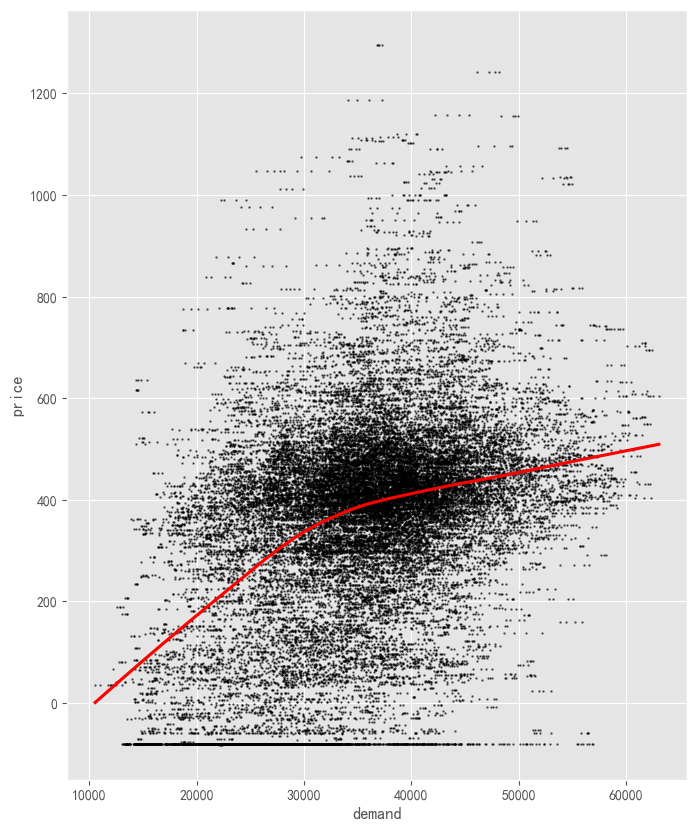

In [ ]:
# 创建一个图形，大小为 8x10 英寸
plt.figure(figsize=(8, 10))

# 绘制回归图（散点图及拟合线）
sns.regplot(
    data=electricity_price.loc["2022"],  # 选择2022年的数据
    x="demand",                         # x 轴的变量为 "demand"
    y="price",                          # y 轴的变量为 "price"
    scatter_kws={                       # 设置散点图的样式
        "s": 0.5,                      # 散点的大小设置为 0.5
        "alpha": 0.6,                  # 散点的透明度设置为 0.6
        "color": "black"               # 散点的颜色设置为黑色
    },
    color="red",                        # 拟合线的颜色设置为红色
    lowess=True                          # 启用局部加权回归（Lowess）以拟合数据
)